In [250]:
import tweepy
import numpy as np
from textblob import TextBlob
import matplotlib.pyplot as plt
import datetime
import cartopy.crs as ccrs
import pandas as pd
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

auth = tweepy.OAuthHandler("8TMMLgLiYXkISHM6SwPcqce43", "LXpNBM098txl8Klcynwc2QkWPFfIlQi7CuOLnJDCGWBzuQe97R")
auth.set_access_token("1309612050830823427-Iv7H1yoYEvrLyiMwHnNZosETitfTYY", "YcRn1mbVtbkckzdD160REiO9hrCO7k3bt3Yzh5EIHwABe")

api = tweepy.API(auth)

In [239]:
def maptweet(string):
    def mapper(x):
        if any(["RT" in x, "@" in x, "http" in x]):
            return ""
        if "#" in x:
            try:
                return x[1:]
            except IndexError:
                return ""

    return " ".join(
        map(mapper, string.split(" "))
    )

data = {
    "trump": [],
    "biden": [],
    "average": []
}

trump = api.get_user("@realDonaldTrump")
biden = api.get_user("@JoeBiden")

average = api.search(q="elections", count=100, tweet_mode="extended")
ttweets = trump.timeline(count=100, tweet_mode="extended")
btweets = biden.timeline(count=100, tweet_mode="extended")

In [240]:
for t in average:
    data["average"].append((TextBlob(filtertweet(t.full_text)), t))
    
for t in ttweets:
    data["trump"].append((TextBlob(filtertweet(t.full_text)), t))
    
for t in btweets:
    data["biden"].append((TextBlob(filtertweet(t.full_text)), t))

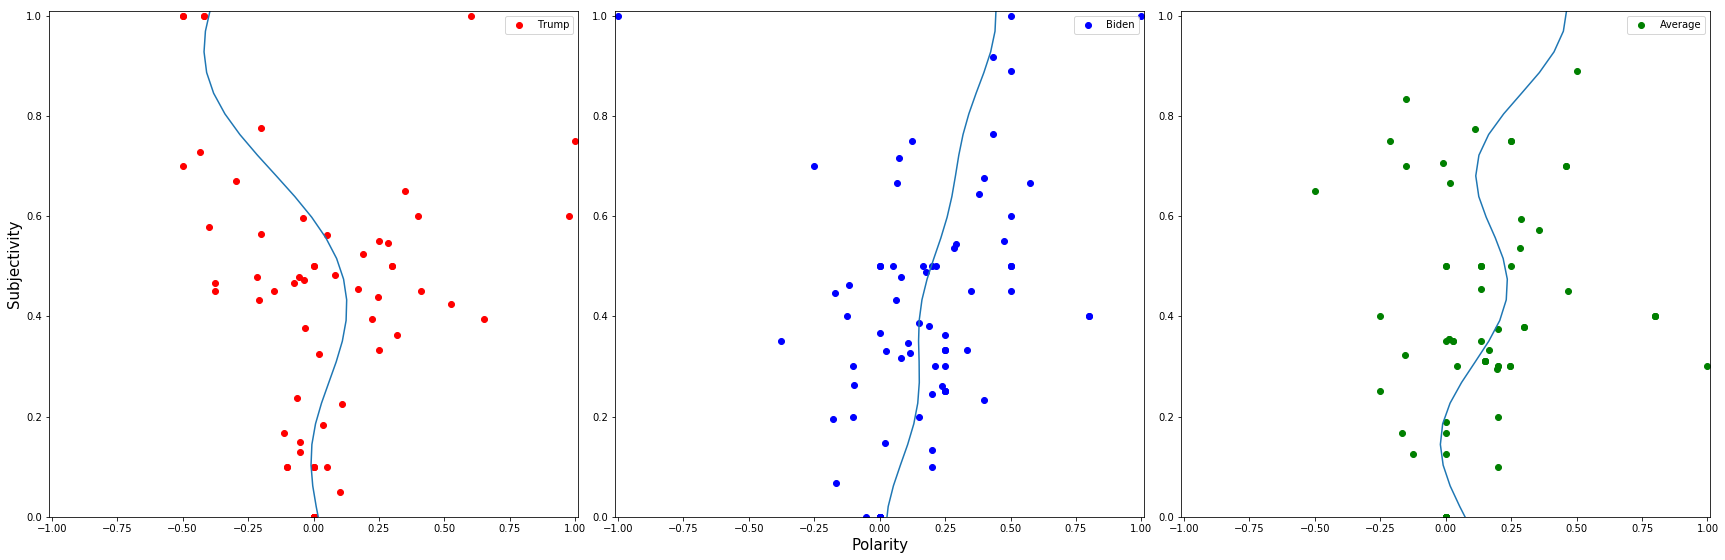

In [264]:
plt.figure()
plt.title("The polarity and subjectivity for the 2020 election candidates", fontsize=20)

# Trump
plt.subplot(131)
X = list(map(lambda x: x[0].sentiment.polarity, data["trump"]))
y = list(map(lambda x: x[0].sentiment.subjectivity, data["trump"]))

plt.scatter(
    X, y,
    label="Trump",
    color="red"
)

reg = SVR().fit([[x] for x in y], X)
eq = lambda x: reg.predict([[x]])
plt.plot(
    np.vectorize(eq)(np.linspace(-1.01, 1.01)),
    np.linspace(-1.01, 1.01)
)

plt.xlim(-1.01, 1.01)
plt.ylim(0, 1.01)
plt.ylabel("Subjectivity", fontsize=15)
plt.legend()

# Biden
plt.subplot(132)
X = list(map(lambda x: x[0].sentiment.polarity, data["biden"]))
y = list(map(lambda x: x[0].sentiment.subjectivity, data["biden"]))

plt.scatter(
    X, y,
    label="Biden",
    color="blue"
)

reg = SVR().fit([[x] for x in y], X)
eq = lambda x: reg.predict([[x]])
plt.plot(
    np.vectorize(eq)(np.linspace(-1.01, 1.01)),
    np.linspace(-1.01, 1.01)
)

plt.xlim(-1.01, 1.01)
plt.ylim(0, 1.01)
plt.xlabel("Polarity", fontsize=15)
plt.legend()

# Average
plt.subplot(133)
X = list(map(lambda x: x[0].sentiment.polarity, data["average"]))
y = list(map(lambda x: x[0].sentiment.subjectivity, data["average"]))

plt.scatter(
    X, y,
    label="Average",
    color="green"
)

reg = SVR().fit([[x] for x in y], X)
eq = lambda x: reg.predict([[x]])
plt.plot(
    np.vectorize(eq)(np.linspace(-1.01, 1.01)),
    np.linspace(-1.01, 1.01)
)

plt.xlim(-1.01, 1.01)
plt.ylim(0, 1.01)
plt.legend()
plt.tight_layout(rect=[0, 0.03, 4, 2])
plt.savefig("Fig1.svg", bbox_inches="tight")      # 3.5in x 10in
plt.show()

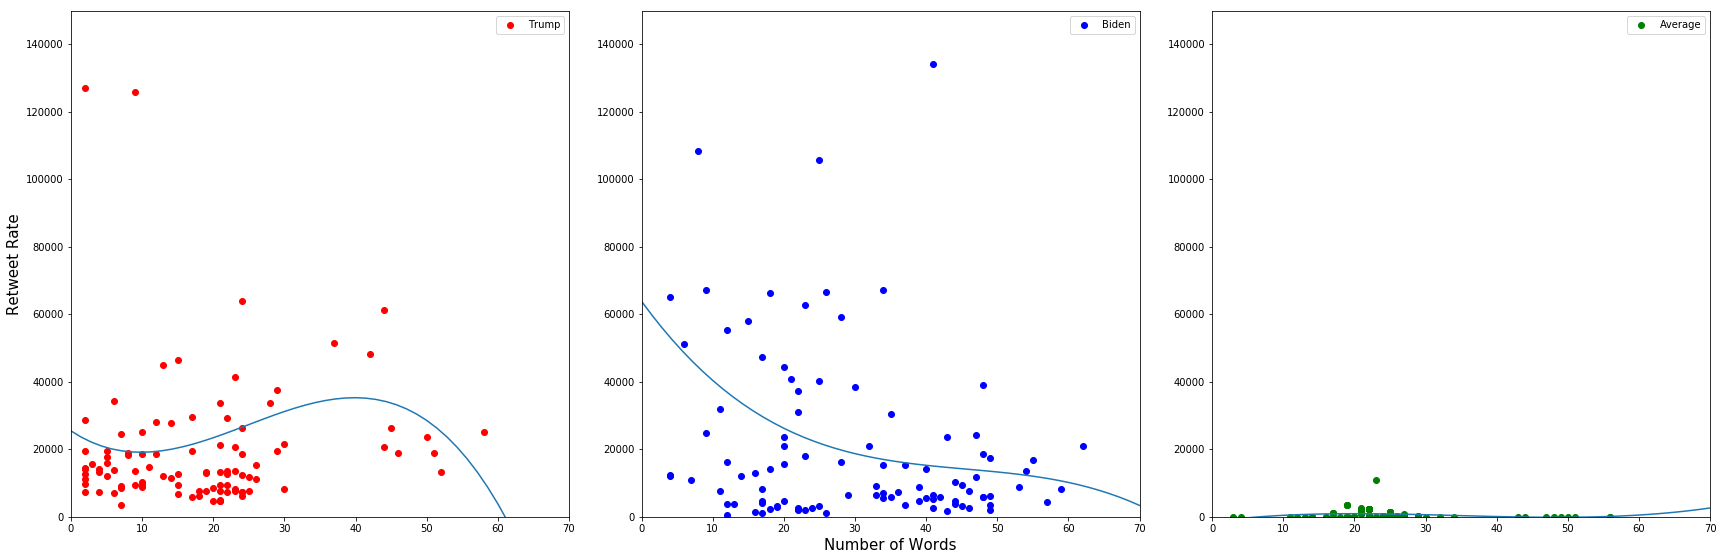

In [242]:
plt.figure()
plt.title("The effect of the number of words on the retweet rate", fontsize=20)

plt.subplot(131)
X = list(map(lambda x: len(x[0].words), data["trump"]))
y = list(map(lambda x: x[1].retweet_count, data["trump"]))
plt.scatter(
    X, y,
    label="Trump",
    color="red"
)

plt.plot(
    np.linspace(0, 70),
    np.poly1d(np.polyfit(X, y, deg=3))(np.linspace(0, 70))
)

plt.xlim(0, 70)
plt.ylim(0, 150000)
plt.ylabel("Retweet Rate", fontsize=15)
plt.legend()

plt.subplot(132)
X = list(map(lambda x: len(x[0].words), data["biden"]))
y = list(map(lambda x: x[1].retweet_count, data["biden"]))
plt.scatter(
    X, y,
    label="Biden",
    color="blue"
)

plt.plot(
    np.linspace(0, 70),
    np.poly1d(np.polyfit(X, y, deg=3))(np.linspace(0, 70))
)

plt.xlim(0, 70)
plt.ylim(0, 150000)
plt.xlabel("Number of Words", fontsize=15)
plt.legend()

plt.subplot(133)
X = list(map(lambda x: len(x[0].words), data["average"]))
y = list(map(lambda x: x[1].retweet_count, data["average"]))
plt.scatter(
    X, y,
    label="Average",
    color="green"
)

plt.plot(
    np.linspace(0, 70),
    np.poly1d(np.polyfit(X, y, deg=3))(np.linspace(0, 70))
)

plt.xlim(0, 70)
plt.ylim(0, 150000)
plt.legend()
plt.tight_layout(rect=[0, 0.03, 4, 2])
plt.savefig("Fig2.svg")
plt.show()

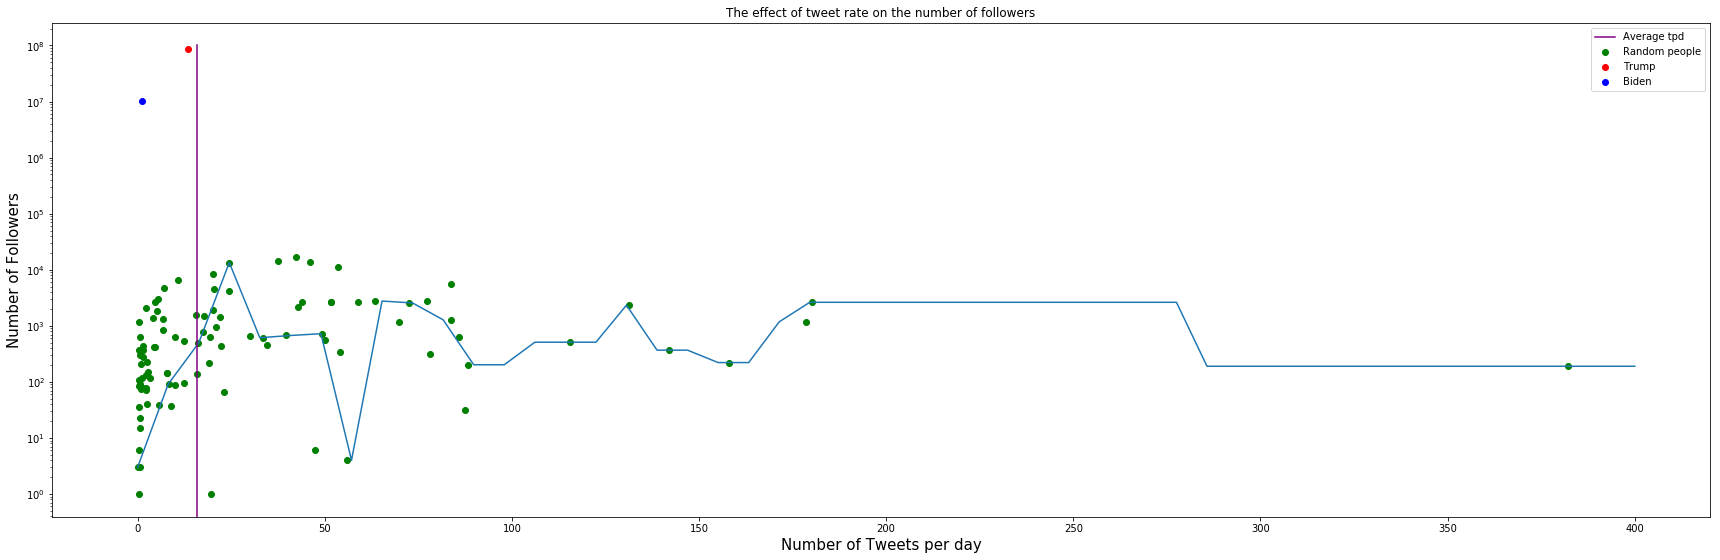

In [253]:
plt.figure()
plt.title("The effect of tweet rate on the number of followers")

random_users = list(map(lambda x: x.user, average))
average_tpd = list(map(
    lambda x: x.statuses_count / (datetime.datetime.now() - x.created_at).days,
    random_users
))

X = average_tpd
y = list(map(lambda x: x.followers_count, random_users))
reg = DecisionTreeRegressor().fit([[x] for x in X], y)
eq = lambda x: reg.predict([[x]])

plt.scatter(
    X,
    y,
    color="green",
    label="Random people"
)

plt.plot(
    (np.linspace(0, 400)),
    np.vectorize(eq)(np.linspace(0, 400))
)

plt.scatter(
    [trump.statuses_count / (datetime.datetime.now() - trump.created_at).days],
    [trump.followers_count],
    color="red",
    label="Trump"
)

plt.scatter(
    [biden.statuses_count / (datetime.datetime.now() - biden.created_at).days],
    [biden.followers_count],
    color="blue",
    label="Biden"
)

plt.plot([np.median(average_tpd), np.median(average_tpd)], [0, pow(10, 8)], color="purple", label="Average tpd")

plt.xlabel("Number of Tweets per day", fontsize=15)
plt.ylabel("Number of Followers", fontsize=15)

plt.yscale("log")
plt.legend()
plt.tight_layout(rect=[0, 0.03, 4, 2])
plt.savefig("Fig3.svg")
plt.show()

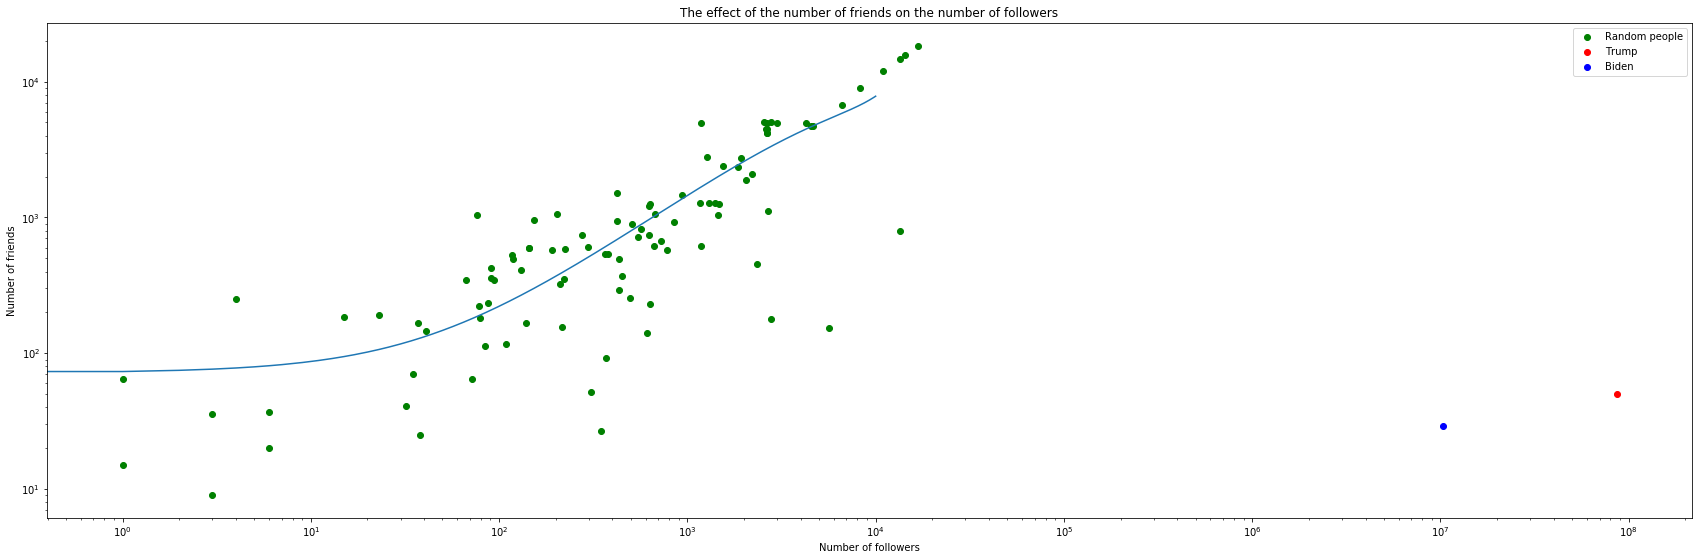

In [258]:
plt.figure()
plt.title("The effect of the number of friends on the number of followers")

X = list(map(lambda x: x.followers_count, random_users))
y = list(map(lambda x: x.friends_count, random_users))

plt.scatter(
    X, y,
    color="green",
    label="Random people"
)

plt.plot(
    np.linspace(0, pow(10, 4), 10000),
    np.poly1d(np.polyfit(X, y, deg=3))(np.linspace(0, pow(10, 4), 10000))
)

plt.scatter(
    [trump.followers_count],
    [trump.friends_count],
    color="red",
    label="Trump"
)

plt.scatter(
    [biden.followers_count],
    [biden.friends_count],
    color="blue",
    label="Biden"
)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of followers")
plt.ylabel("Number of friends")
plt.legend()
# plt.xlim(0, 50000)
# plt.ylim(0, 20000)
plt.tight_layout(rect=[0, 0.03, 4, 2])
plt.savefig("Fig4.svg")
plt.show()

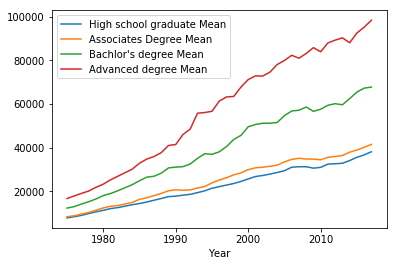

In [245]:
pd.read_csv("../../Data.csv").dropna().applymap(lambda x: float("".join(str(x).split(",")))).set_index("Year")[[
    "High school graduate Mean", 
    "Associates Degree Mean", 
    "Bachlor's degree Mean", 
"Advanced degree Mean"]].plot()

In [246]:
len(set(map(lambda x: x.friends_count, random_users)))

97

In [261]:
import pickle
pickle.dumps(reg)

b'\x80\x03csklearn.tree._classes\nDecisionTreeRegressor\nq\x00)\x81q\x01}q\x02(X\t\x00\x00\x00criterionq\x03X\x03\x00\x00\x00mseq\x04X\x08\x00\x00\x00splitterq\x05X\x04\x00\x00\x00bestq\x06X\t\x00\x00\x00max_depthq\x07NX\x11\x00\x00\x00min_samples_splitq\x08K\x02X\x10\x00\x00\x00min_samples_leafq\tK\x01X\x18\x00\x00\x00min_weight_fraction_leafq\nG\x00\x00\x00\x00\x00\x00\x00\x00X\x0c\x00\x00\x00max_featuresq\x0bNX\x0e\x00\x00\x00max_leaf_nodesq\x0cNX\x0c\x00\x00\x00random_stateq\rNX\x15\x00\x00\x00min_impurity_decreaseq\x0eG\x00\x00\x00\x00\x00\x00\x00\x00X\x12\x00\x00\x00min_impurity_splitq\x0fNX\x0c\x00\x00\x00class_weightq\x10NX\x07\x00\x00\x00presortq\x11X\n\x00\x00\x00deprecatedq\x12X\t\x00\x00\x00ccp_alphaq\x13G\x00\x00\x00\x00\x00\x00\x00\x00X\x0e\x00\x00\x00n_features_in_q\x14K\x01X\x0b\x00\x00\x00n_features_q\x15K\x01X\n\x00\x00\x00n_outputs_q\x16K\x01X\r\x00\x00\x00max_features_q\x17K\x01X\x05\x00\x00\x00tree_q\x18csklearn.tree._tree\nTree\nq\x19K\x01cnumpy.core.multiarray\n_